In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
df_sp = pd.read_csv('../data/interim/1_0_data_sp.csv')
df_sem = pd.read_csv('../data/interim/1_1_data_sem.csv')

In [3]:
df_sp.head(1)

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age
0,172843326579763,1016.090081,401.723052,1021.80528,395.415,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0


## Data Preprocessing

### Drop Null Value

In [4]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31156 entries, 0 to 31155
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       31156 non-null  int64  
 1   MovingTarget_X  31156 non-null  float64
 2   MovingTarget_Y  31156 non-null  float64
 3   EyeTracker_X    31156 non-null  float64
 4   EyeTracker_Y    31156 non-null  float64
 5   name            31156 non-null  object 
 6   date            31156 non-null  object 
 7   category        31156 non-null  object 
 8   id              31156 non-null  object 
 9   row_id          29955 non-null  float64
 10  HR_before       29955 non-null  float64
 11  HR_after        29955 non-null  float64
 12  age             29955 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.1+ MB


In [5]:
# df_sp = df_sp.drop(['perc_O2'], axis = 1)
# df_sem = df_sem.drop(['perc_O2'], axis = 1)

In [6]:
df_sp = df_sp.dropna()

df_sem = df_sem.dropna()

# Feature Engineering

## Smooth Pursuit

In [7]:
df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0


Counting Distance

In [8]:
# Counting Distance
df_sp['sp_distance'] = (df_sp['MovingTarget_X'] - df_sp['EyeTracker_X'])**2 + (df_sp['MovingTarget_Y'] - df_sp['EyeTracker_Y'])**2

df_sp['sp_distance'] = np.sqrt(df_sp['sp_distance'])

df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,sp_distance
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,8.512051
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,33.322729
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,31.148104
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.993199
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.794226


Counting angle

In [9]:
screen_width = 1920
screen_height = 1080

screen_center = [screen_width//2, screen_height//2] 

df_sp_angle = df_sp.copy()

df_sp_angle['vector_e_x'] = df_sp_angle['EyeTracker_X'] - screen_center[0]
df_sp_angle['vector_e_y'] = df_sp_angle['EyeTracker_Y'] - screen_center[1]

df_sp_angle['vector_g_x'] = df_sp_angle['MovingTarget_X'] - screen_center[0]
df_sp_angle['vector_g_y'] = df_sp_angle['MovingTarget_Y'] - screen_center[1]

# df_sp['vector_e'] = [df_sp['vector_e_x'], df_sp['vector_e_y']]
# df_sp['vector_g'] = [df_sp['vector_g_x'], df_sp['vector_g_y']]

df_sp_angle['vector_e_length'] = df_sp_angle['vector_e_x']**2 + df_sp_angle['vector_e_y']**2
df_sp_angle['vector_e_length'] = np.sqrt(df_sp_angle['vector_e_length'])

df_sp_angle['vector_g_length'] = df_sp_angle['vector_g_x']**2 + df_sp_angle['vector_g_y']**2
df_sp_angle['vector_g_length'] = np.sqrt(df_sp_angle['vector_g_length'])

df_sp_angle['vector_e_dot_g'] = df_sp_angle['vector_e_x'] * df_sp_angle['vector_g_x'] + df_sp_angle['vector_e_y'] * df_sp_angle['vector_g_y']

df_sp_angle['sp_angle'] = np.arccos(df_sp_angle['vector_e_dot_g'] / (df_sp_angle['vector_e_length'] * df_sp_angle['vector_g_length']))

In [10]:
df_sp['sp_angle'] = df_sp_angle['sp_angle']
df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,sp_distance,sp_angle
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,8.512051,0.018603
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,33.322729,0.087667
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,31.148104,0.079717
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.993199,0.081175
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.794226,0.081834


### Aggregation for Smooth Pursuit

In [11]:
df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,sp_distance,sp_angle
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,8.512051,0.018603
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,33.322729,0.087667
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,31.148104,0.079717
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.993199,0.081175
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.794226,0.081834


In [12]:
df_sp_row_id = df_sp[['id','row_id']].drop_duplicates()
df_sp = df_sp[['id', 'HR_before', 'HR_after', 'sp_distance', 'sp_angle']]

# Group by 'category' and apply aggregation functions
df_sp_sum = df_sp.groupby('id').agg({
    'sp_distance': 'sum',    # Sum the values in 'values_1'
    'sp_angle': 'sum'    # Calculate the mean of 'values_2'
})

# Group by 'category' and apply aggregation functions
df_sp_average = df_sp.groupby('id').agg({
    'sp_distance': 'mean',    # Sum the values in 'values_1'
    'sp_angle': 'mean'    # Calculate the mean of 'values_2'
})

# Group by 'category' and apply aggregation functions
df_sp_median = df_sp.groupby('id').agg({
    'sp_distance': 'median',    # Sum the values in 'values_1'
    'sp_angle': 'median'    # Calculate the mean of 'values_2'
})

df_sp = df_sp[['id', 'HR_before', 'HR_after']]
df_sp = df_sp.groupby('id').agg('mean')

df_sp['sp_total_distance'] = df_sp_sum['sp_distance']
df_sp['sp_average_distance'] = df_sp_average['sp_distance']
df_sp['sp_median_distance'] = df_sp_median['sp_distance']

df_sp['sp_total_angle'] = df_sp_sum['sp_angle']
df_sp['sp_average_angle'] = df_sp_average['sp_angle']
df_sp['sp_median_angle'] = df_sp_median['sp_angle']

df_sp = df_sp.reset_index()
df_sp = pd.merge(df_sp, df_sp_row_id, on='id', how='inner')

In [13]:
df_sp.head(15)

,id,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id
0,aaliyah-2024-10-21_SP_1729492081,94.0,141.0,79099.036519,69.690781,55.565160,229.927899,0.202580,0.074614,26.0
1,ar-2024-10-09_SP_1728433242,72.0,120.0,40146.187277,33.427300,30.113397,118.172835,0.098395,0.056699,1.0
2,ar-2024-10-10_SP_1728533147,84.0,134.0,32685.571041,27.215296,25.021036,204.802680,0.170527,0.090627,3.0
3,ar-2024-10-12_SP_1728718590,94.0,146.0,44043.556311,36.672403,35.104838,131.801018,0.109743,0.060777,5.0
4,ar-2024-10-13_SP_1728792490,83.0,132.0,28703.569543,23.899725,16.529260,101.726948,0.084702,0.033269,9.0
5,ar-2024-10-14_SP_1728863077,70.0,132.0,28257.159878,23.528027,22.943240,115.369011,0.096061,0.057553,11.0
6,ar-2024-10-15_SP_1728983092,68.0,124.0,29204.750171,24.317028,21.586166,132.737140,0.110522,0.056654,13.0
7,ar-2024-10-22_SP_1729587421,68.0,144.0,34262.910751,28.528652,23.436273,94.747562,0.078891,0.052490,29.0
8,bella-2024-10-18_SP_1729238753,85.0,140.0,54624.286073,45.482336,34.291648,206.149969,0.171649,0.065083,19.0
9,bian-2024-10-12_SP_1728719688,96.0,143.0,39699.269704,33.055179,28.681657,178.329899,0.148485,0.075349,8.0


## Saccadic Eye Movement

NOTE: THIS SECTION STILL NEED MORE ATTENTION

In [14]:
df_sem.tail(5)

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age
29797,172872042219531,1020.0,450.0,1046.252736,455.985405,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0
29798,172872042223670,1020.0,450.0,1046.422656,457.283250,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0
29799,172872042227852,1020.0,450.0,1046.963851,457.761510,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0
29800,172872042232063,1020.0,450.0,1046.960064,458.601633,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0
29801,172872042236201,1020.0,450.0,1046.921328,459.116910,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0


In [15]:
# Convert the Unix timestamp to a normal timestamp (assuming it's in microseconds)
df_sem['Timestamp'] = df_sem['Timestamp'] //100  # Convert from microseconds to seconds
df_sem['datetime_timestamp'] = pd.to_datetime(df_sem['Timestamp'], unit='ms', utc=True)  # Convert to datetime

In [16]:
df_sem.tail()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,datetime_timestamp
29797,1728720422195,1020.0,450.0,1046.252736,455.985405,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0,2024-10-12 08:07:02.195000+00:00
29798,1728720422236,1020.0,450.0,1046.422656,457.283250,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0,2024-10-12 08:07:02.236000+00:00
29799,1728720422278,1020.0,450.0,1046.963851,457.761510,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0,2024-10-12 08:07:02.278000+00:00
29800,1728720422320,1020.0,450.0,1046.960064,458.601633,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0,2024-10-12 08:07:02.320000+00:00
29801,1728720422362,1020.0,450.0,1046.921328,459.116910,han,2024-10-12,SEM,han-2024-10-12_SEM_1728720279,6.0,86.0,120.0,21.0,2024-10-12 08:07:02.362000+00:00


In [17]:
# Filter the moving target to keep only rows with max or min values 
max_value = df_sem['MovingTarget_X'].max()
min_value = df_sem['MovingTarget_X'].min()

df_sem = df_sem[(df_sem['MovingTarget_X'] == max_value) | (df_sem['MovingTarget_X'] == min_value)]

# Create a discrete signal
df_sem['MovingTarget_X_discrete'] = np.where(df_sem['MovingTarget_X'] == max_value, max_value, 
                             np.where(df_sem['MovingTarget_X'] == min_value, min_value, np.nan))

df_sem['MovingTarget_X_discrete'] = df_sem['MovingTarget_X_discrete'].replace(max_value, 'right')
df_sem['MovingTarget_X_discrete'] = df_sem['MovingTarget_X_discrete'].replace(min_value, 'left')



In [18]:
def check_if_eye_is_inside_the_circle(MovingTarget_X, MovingTarget_Y, EyeTracker_X, EyeTracker_Y, circle_radius):
    position = (EyeTracker_X - MovingTarget_X)**2 + (EyeTracker_Y - MovingTarget_Y)**2
    if position <= circle_radius**2:
        return True
    else:
        return False

In [19]:
df_sem_row_id = df_sem[['id','row_id']].drop_duplicates()
all_latency = []
discrete = ''
counting = False
start_time_change = 0
circle_radius = 20

for id in df_sem.id.unique():
    latency = []
    df_sem_id = df_sem[df_sem['id'] == id ]
    for row in df_sem_id.itertuples():
        # Check if the previous discrete is changing
        if discrete != row.MovingTarget_X_discrete:
            discrete = row.MovingTarget_X_discrete
            counting = True
            start_time_change = row.datetime_timestamp

        # If counting and eye is inside the circle, calculate latency
        if counting and check_if_eye_is_inside_the_circle(row.MovingTarget_X, row.MovingTarget_Y, row.EyeTracker_X, row.EyeTracker_Y, circle_radius):
            latency_delta = row.datetime_timestamp - start_time_change  # This is a timedelta object
            latency_in_milliseconds = latency_delta.total_seconds() * 1000  # Convert timedelta to milliseconds
            latency.append(latency_in_milliseconds)  # Append latency in milliseconds
            counting = False  # Stop counting after latency is recorded
            start_time_change = 0  # Reset start time

    all_latency.append(latency)

In [20]:
sum_latency_list = []
mean_latency_list = []
median_latency_list = []

for latency in all_latency:
    sum_latency_list.append(np.sum(latency))
    mean_latency_list.append(np.mean(latency))
    median_latency_list.append(np.median(latency))

/home/rayhanadi/Project/capstone-a06-ml-workspace/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rayhanadi/Project/capstone-a06-ml-workspace/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
df_latency = pd.DataFrame()
df_latency['id'] = df_sem.id.unique()
df_latency['total_latency'] = sum_latency_list
df_latency['mean_latency'] = mean_latency_list
df_latency['median_latency'] = median_latency_list

df_latency = pd.merge(df_latency, df_sem_row_id, on='id', how='left')

## Merge SEM result into SP

In [22]:
df_sp = df_sp.reset_index()
df_engineered = pd.merge(df_sp, df_latency, left_on='row_id', right_on='row_id',how='inner')

In [23]:
df_engineered = df_engineered.drop(['index', 'id_x', 'id_y'], axis = 1)

## Create VO2MAX Feature

In [24]:
df_engineered.head(1)

,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id,total_latency,mean_latency,median_latency
0,94.0,141.0,79099.036519,69.690781,55.56516,229.927899,0.20258,0.074614,26.0,7956.0,1326.0,981.5


In [25]:
df_engineered['vo2_max'] = 15.3 * df_engineered['HR_after'] / df_engineered['HR_before']

# Exploratory Data Analysis

## Pearson Correlation 

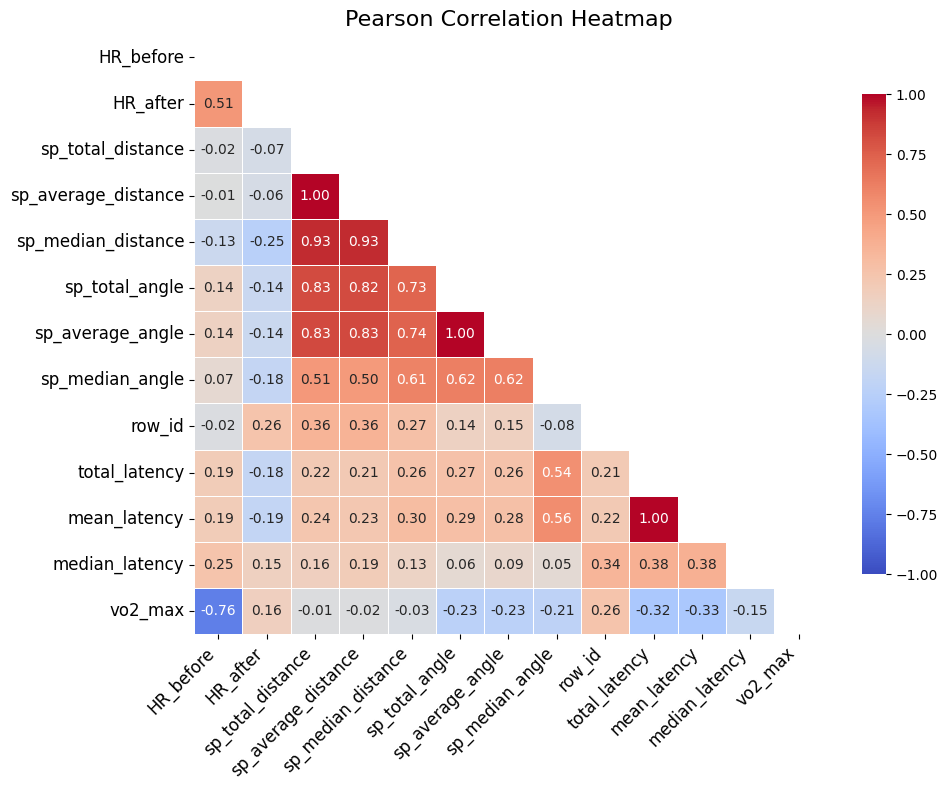

In [26]:
# Compute Pearson correlation
correlation_matrix = df_engineered.corr(method='pearson')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a mask for the upper triangle (optional, to avoid showing duplicate values)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, 
            linewidths=0.5, cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1)

# Improve readability
plt.title('Pearson Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## Save Data into csv

In [27]:
df_engineered.to_csv('../data/interim/2_data_engineered.csv', index=False)

## Some Visualization

In [28]:
df_trial = df_sem[df_sem['id'] =='bian-2024-10-12_SEM_1728719688']
df_trial[1000:1005]

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,datetime_timestamp,MovingTarget_X_discrete
14821,1728719848651,1020.0,450.0,913.906800,566.870580,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:28.651000+00:00,right
14822,1728719849569,1020.0,450.0,1011.843936,491.444847,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.569000+00:00,right
14823,1728719849611,1020.0,450.0,1006.493760,490.448997,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.611000+00:00,right
14824,1728719849652,1020.0,450.0,1006.447738,489.237714,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.652000+00:00,right
14825,1728719849694,1020.0,450.0,1004.233968,494.967555,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.694000+00:00,right


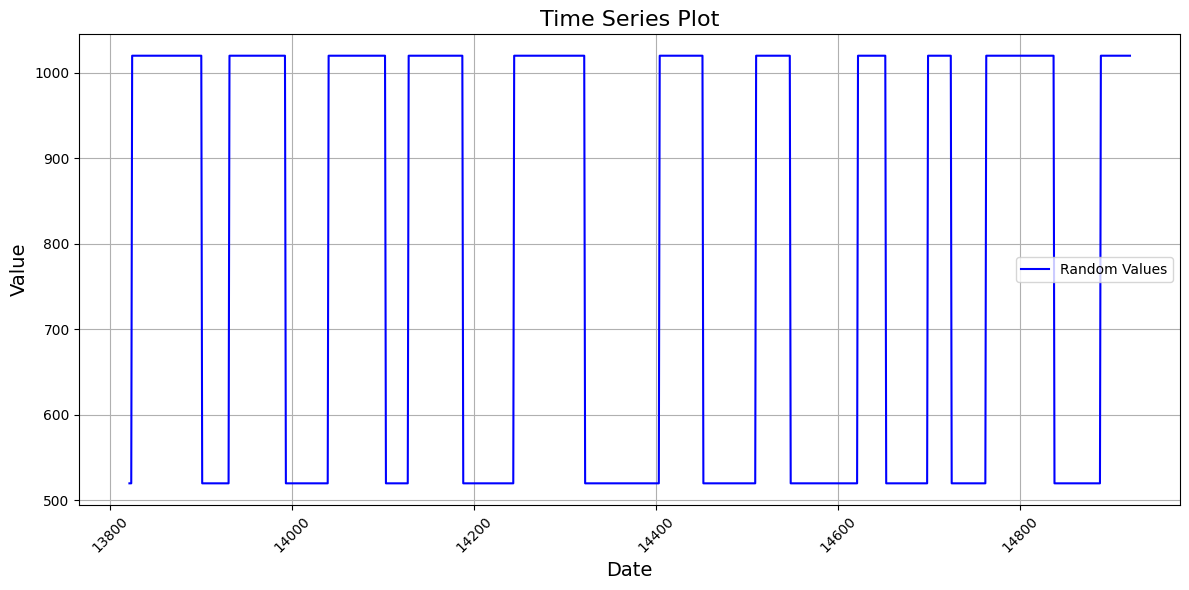

In [29]:
# Plotting the time series

df_trial = df_sem[df_sem['id'] =='bian-2024-10-12_SEM_1728719688']

# Identify the maximum and minimum values
max_value = df_trial['MovingTarget_X'].max()
min_value = df_trial['MovingTarget_X'].min()

# Filter the DataFrame to keep only rows with max or min values
df_filtered = df_trial[(df_trial['MovingTarget_X'] == max_value) | (df_trial['MovingTarget_X'] == min_value)]

plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered['MovingTarget_X'], label='Random Values', color='blue')

# Adding titles and labels
plt.title('Time Series Plot', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid()
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()